# The Pink Demon: Analyzing Melee's Jigglypuff

#### Roman Grigoryev

## Introduction

*Super Smash Bros. Melee*, released on November 21st, 2001 for the Nintendo GameCube, is the second installment of the critically-acclaimed *Super Smash Bros.* franchise which today boasts five games across five different platforms. Today, *Melee* remains a popular game with an extremely dedicated cult following and a thriving tournament scene. This popularity can be attributed to *Melee*'s extraordinary depth. The game features remarkably complex movement mechanics and has a combo system unlike any other fighting game's. Additionally, the technical skill barrier is very high due to many techniques being the result of quirks of the game engine rather than something that was deliberately programmed in.

Due to *Melee*'s age, almost no resources existed that would enable any sort of rigorous analysis on game data. Enter: [Project Slippi](www.slippi.gg). Slippi is a very new framework that records information about a game of *Melee* in the form of a list of frames (a frame is a single "cycle" of the game where game data is updated). *Melee* runs at 60 frames per second, meaning that each second is converted to 60 frame objects by Slippi. Using this framework and some non-trivial interpretation of what each frame signifies, we are able to derive complex information about the game which we can then analyze.

In this project, I will be focusing on a single character from the game's cast: Jigglypuff, the Balloon Pokemon. Jigglypuff is an anomaly in *Melee*'s roster. She plays completely unlike any other character in the game and sees relatively little play in the higher skill levels due to how *weird* she is. Interestingly, the current top player in the world (at time of writing), HungryBox (HBox), plays almost exclusively Jigglypuff, yet among the top 100 players in the world, only four players use Jigglypuff in any capacity.

As such, relatively little information exists about her outside of conventional *Melee* wisdom. The purpose of this report is to analyze some of Jigglypuff's characteristics as a character in competitive *Melee* and see how the data aligns with accepted explanations from the *Melee* community.

## Dataset

The data for this project is taken from [Project Slippi](www.slippi.gg). We will be using the latest 300 games featuring Jigglypuff. Project Slippi does not track any identifying information about the players except the in-game nickname (tag) they used in during the match. As such, we have no way of distinguishing player skill levels. This will provide us with a "vertical slice" as we will see trends from all levels of play.

#### The HungryBox Factor

HungryBox (Juan DeBiedma), the current \#1 *Melee* player in the world, is a Jigglypuff main and a total outlier. It cannot be understated how influential HBox has been in the *Melee* world for Jigglypuff mains - if one wishes to learn how to play her, they must start by studying HBox: the man who perfected Jigglypuff. As such, some of his habits have found their way into the common consciousness of Jigglypuff mains worldwide, which we must keep in mind.

It is also important to note that HBox refuses to play "friendlies" or casual games with no stakes. This means that other players have far less familiarity playing against the already-rare Jigglypuff, meaning they will be less prepared for the game. Compare this to HBox, who has played thousands of games against every other character.

## Setup

We'll be using the usual python 3 libraries typically used for data science: numpy, pandas, seaborn, etc.

Of course we will also be using the python Slippi parser found [here](https://github.com/hohav/py-slippi)

Additionally, we'll employ some minor optimization techniques for memory management and forcing garbage collection found in the gc library. This is not absolutely necessary, but due to the poor specs of my workstation it will yield a significant improvement in speed.

In [1]:
# Import all the bits and bobs we'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import slippi
from slippi import Game
import os
import sys
import matplotlib.image as mpimg 
import matplotlib
import gc

## Preprocessing

For convenience, we'll assign names and in-game codes to every character and stage, which we will use later on to simplify boilerplate code. We will also define stage boundaries for future use. These boundary values are programmed into the game iteself. The source for these values can be found in this [smashboards thread](http://smashboards.com/posts/18643652).

Additionally, we'll define some workhorse methods which will allow conversions between the different identifiers of a stage or character. For instance, if we have the code to represent Mario, we can use a method to fetch the corresponding name "mario".

In [2]:
# Character bindings
jiggs = (slippi.id.InGameCharacter.JIGGLYPUFF, 'jigglypuff')
mario = (slippi.id.InGameCharacter.MARIO, 'mario')
fox = (slippi.id.InGameCharacter.FOX, 'fox')
falcon = (slippi.id.InGameCharacter.CAPTAIN_FALCON, 'captain_falcon')
dk = (slippi.id.InGameCharacter.DONKEY_KONG, 'donkey_kong')
kirby = (slippi.id.InGameCharacter.KIRBY, 'kirby')
bowser = (slippi.id.InGameCharacter.BOWSER, 'bowser')
link = (slippi.id.InGameCharacter.LINK, 'link')
sheik = (slippi.id.InGameCharacter.SHEIK, 'sheik')
ness = (slippi.id.InGameCharacter.NESS, 'ness')
peach = (slippi.id.InGameCharacter.PEACH, 'peach')
popo = (slippi.id.InGameCharacter.POPO, 'ice_climbers')
nana = (slippi.id.InGameCharacter.NANA, 'nana')
pikachu = (slippi.id.InGameCharacter.PIKACHU, 'pikachu')
samus = (slippi.id.InGameCharacter.SAMUS, 'samus')
yoshi = (slippi.id.InGameCharacter.YOSHI, 'yoshi')
mewtwo = (slippi.id.InGameCharacter.MEWTWO, 'mewtwo')
luigi = (slippi.id.InGameCharacter.LUIGI, 'luigi')
marth = (slippi.id.InGameCharacter.MARTH, 'marth')
zelda = (slippi.id.InGameCharacter.ZELDA, 'zelda')
y_link = (slippi.id.InGameCharacter.YOUNG_LINK, 'young_link')
doc = (slippi.id.InGameCharacter.DR_MARIO, 'dr_mario')
falco = (slippi.id.InGameCharacter.FALCO, 'falco')
pichu = (slippi.id.InGameCharacter.PICHU, 'pichu')
gnw = (slippi.id.InGameCharacter.GAME_AND_WATCH, 'game_and_watch')
ganon = (slippi.id.InGameCharacter.GANONDORF, 'ganondorf')
roy = (slippi.id.InGameCharacter.ROY, 'roy')

all_characters = [jiggs, mario, fox, falcon, dk, kirby, bowser, link, sheik, ness, peach, popo, nana,\
                  pikachu, samus, yoshi, mewtwo, luigi, marth, zelda, y_link, doc, falco, pichu, \
                  gnw, ganon, roy]

# Bindings for the legal stages
fod = (slippi.id.Stage.FOUNTAIN_OF_DREAMS, 'fountain of dreams', 'fod.png')
stadium = (slippi.id.Stage.POKEMON_STADIUM, 'pokemon stadium', 'stadium.png')
yoshis = (slippi.id.Stage.YOSHIS_STORY, 'yoshi\'s story', 'yoshis.png')
dreamland = (slippi.id.Stage.DREAM_LAND_N64, 'dreamland', 'dreamland.png')
bf = (slippi.id.Stage.BATTLEFIELD, 'battlefield', 'bf.png')
fd = (slippi.id.Stage.FINAL_DESTINATION, 'final destination', 'fd.png')

all_stages = [fod, stadium, yoshis, dreamland, bf, fd]

stage_boundaries = {
    fod[1]: ((-198.75, 198.75), (-146.25, 202.5)),  # FOD
    stadium[1]: ((-230, 230), (-111, 180)),         # Stadium
    yoshis[1]: ((-175.7, 173.6), (-91, 168)),       # Yoshi's story
    dreamland[1]: ((-255.00, 255.00), (-123, 250)), # Dreamland
    bf[1]: ((-224, 224), (-108.8, 200)),            # BF
    fd[1]: ((-246.00, 246), (-140, 188))            # FD
}

# Optimized to run in O(n)! Wow!!!!
def character_name(char):
    global all_characters
    for c in all_characters:
        if c[0] == char: return c[1]
    return None

def stage_name(stage):
    global all_stages
    for s in all_stages:
        if s[0] == stage: return s[1]
    return None

def stage_filename(stage):
    global all_stages
    for s in all_stages:
        if s[0] == stage: return s[2]
    return None

A character state indicates what a character's status is. There are hundreds of states encompassing all possible conditions a character can be in. This includes things like jumping, running, crouching, and being stuck in hitstun (briefly being unable to act after getting hit with an attack). A comprehensive list of all character states can be found in [this thread](https://smashboards.com/threads/list-of-all-possible-character-states-ie-downdamage-downwait.400270/).

Here, we define methods which we'll use to check the meaning of a character state.

In [3]:
# Checks whether this is a damaged state
def is_damaged(state):
    return 75 <= state <= 91

# Checks whether this is a grabbed state
def is_grabbed(state):
    return 223 <= state <= 236

# Checks whether this is a teching state
def is_teching(state):
    return 199 <= state <= 204

# Checks whether this is a state in which the character is in control
def is_in_control(state):
    
    ground = 14 <= state <= 24 
    squat = 39 <= state <= 41
    ground_attack = 44 <= state <= 64
    grabbing = state == 212
    
    return ground or squat or ground_attack or grabbing

# Checks whether this is a death state
def is_dead(state):
    return 0 <= state <= 10

# Checks whether this is an attacking state
def is_attacking(state):
    return 44 <= state <= 69

# Calculates the damage taken from an attack
# NOTE: ARGUMENTS MUST BE frame.post
def damage_taken(pre_frame, post_frame):
    return post_frame.damage - pre_frame.damage

# Checks if the state is one of grabbing
def is_grabbing(state):
    return state == 212 or state == 214

# Checks if the state is holding an opponent from a successful grab
def is_holding(state):
    return state == 213 or 215 <= state <= 218

# Checks if the state is one of respawning
def is_respawn(state):
    return state == 12 or state == 13

Here we define additional boilerplate code for repetitive calculations such as determining whether Jigglypuff was the victor of a game and verifying that a particular game does not contain corrupt data. Unfortunately this does happen in practice, likely due to Slippi still being a young program.

Additionally, we declare our main dataframe for the program: `all_games`. This dataframe will contain some "meta-information" about each game:

- The controller port Jigglypuff is plugged into
- The controller port the opponent is plugged into
- The opponent's character (the "matchup")
- The stage the game takes place on
- Whether Jigglypuff won the game
- The duration of the game in frames (60 frames = 1 second)
- The filename of the game. We need this because the file contains a tremendous amount of information which does not easily lend itself to a dataframe format

Finally, we define a method that will validate a particular game and add it to the `all_games` dataframe.

In [4]:
all_games = pd.DataFrame(columns = ['jiggs_port', 
                                    'opp_port', 
                                    'matchup', 
                                    'stage', 
                                    'win', 
                                    'duration', 
                                    'filename'])

# Determines if jigglypuff won
def jiggs_won(game, j_port, opp_port):
    
    # Get the last frame
    last_frame = game.frames[-1]
    
    # The post-processing result of the last frame
    j_post = last_frame.ports[j_port].leader.post
    opp_post = last_frame.ports[opp_port].leader.post
    
    # First, compare stock counts
    j_stocks = j_post.stocks
    opp_stocks = opp_post.stocks
    
    if j_stocks > opp_stocks: return True
    if j_stocks < opp_stocks: return False
    
    # If stocks are the same, compare percent
    j_dmg = j_post.damage
    opp_dmg = opp_post.damage
    
    # It's almost unheard of for both players to end at the exact same percent.
    # In this extremely unlikely event, we give the match to jiggs
    if j_dmg <= opp_dmg: return True
    else: return False
    

# Add a single game to our dataframe
def add_game(game, characters, fname):
    
    global all_games
    
    j_port = characters[0][0]
    opp_port = characters[1][0]
    
    game_data = {
        'jiggs_port': j_port,
        'opp_port': opp_port,
        'matchup': character_name(characters[1][1]),
        'stage': stage_name(game.start.stage),
        'win': jiggs_won(game, j_port, opp_port),
        'duration': game.metadata.duration,
        'filename': fname
    }
    
    all_games = all_games.append(game_data, ignore_index = True)
    
# Makes sure the game is not corrupt before returning it
def validate_game(fname):
    try:
        game = Game('games/' + fname)
        return game
    except KeyboardInterrupt:
        sys.exit()
    except:
        print('Game ' + fname + ' contains corrupt data.')
        return None

## Populating the Dataframe

Here, we run through every game in our dataset. We perform some basic operations on each game to determine the port numbers of Jigglypuff and the opponent (since these port numbers are required in order to access character states) and discard any "dittos" AKA "mirror matches"; games where it's Jigglypuff vs. Jigglypuff. Such games are out of the scope of this project and we're not interested in the data that can be gleaned from them anyway.

In [5]:
for fname in os.listdir('games/'):

    game = validate_game(fname)
    
    # If the game is corrupt, do nothing
    if not game:
        continue
        
    # First frame of the game
    frame_one = game.frames[1]
    
    ports = frame_one.ports
    characters = list()

    for port_num in range(4):
        if ports[port_num]:
            char = ports[port_num].leader.post.character
            characters.append((port_num, char))
            
    # We don't care about dittos
    if characters[0][1] == jiggs[0] and characters[1][1] == jiggs[0]:
        pass
    
    # Put jiggs in index 0
    else:
        if characters[0][1] != jiggs[0]:
            characters.reverse()
        add_game(game, characters, fname)

WARNING unknown event code: 0x3a
WARNING unknown Attack: 87
WARNING unknown Attack: 59


In [6]:
all_games.head()

jiggs_port opp_port matchup            stage    win duration  \
0          1        0     fox    yoshi's story   True     6381   
1          1        0     fox  pokemon stadium  False    10713   
2          3        0     fox      battlefield   True     7043   
3          0        3   marth      battlefield   True    17727   
4          0        3     fox      battlefield  False    11056   

                              filename  
0           6-Game_20190609T152407.slp  
1           6-Game_20190609T153157.slp  
2  Station 10-Game_20190824T085631.slp  
3    BTSSmash-Game_20190922T182503.slp  
4          50-Game_20190609T205718.slp

## Finding Matchup Winrates

First and foremost, we'll look at some of the most fundamental character-specific information: the matchup chart. A matchup chart indicates how much of an advantage a certain character has against every other character. In *Melee*, these advantages are divided into eight categories:

1. Large disadvantage
2. Disadvantage
3. Slight disadvantage
4. Even
5. Slight advantage
6. Advantage
7. Large advantage (AKA hard counter)
8. Mirror match (AKA ditto)

Matchups are symmetric, so if character X has an advantage against character Y, then character Y has a disadvantage against character X.

A full matchup chart for *Melee* can be found [here](https://www.ssbwiki.com/Character_matchup_(SSBM)).
For Jigglypuff, community / pro consensus states that she has a slight disadvantage against [Fox](https://www.ssbwiki.com/Fox_(SSBM)) and an even-or-better matchup against the rest of the cast. Here, we'll compare this consensus to the actual winrates from our analyzed games. 

*Note that we will only look at matchups for which we have ten or more games.*

In [7]:
x_chars = list()
y_winrate = list()

for character in all_characters:
    
    name = character[1]
    
    filtered_games = all_games[all_games.matchup == name]
    
    total_games = filtered_games.shape[0]
    total_wins = filtered_games[filtered_games.win == True].shape[0]
    
    # Only look at matchups for which we have ten or more games
    if total_games >= 10:
        x_chars.append(name)
        y_winrate.append(float(total_wins)/float(total_games))

overall_games = all_games.shape[0]
overall_wins = all_games[all_games.win == True].shape[0]

average_winrate = float(overall_wins)/float(overall_games)

# Now we standardize our data
y_winrate_std = list(map(lambda x: (x - .5), y_winrate))

fig = plt.figure(1, [10, 8])
plt.title("Jigglypuff Winrates vs The Rest of the Cast")
plt.xlabel("Opponent Character")
plt.ylabel("Jigglypuff Winrate Percentage (0.00 = Even Matchup)")
plt.bar(x_chars, y_winrate_std, color = 'green')

# Free memory
x_chars = None
y_winrate = None
gc.collect()

4

Our results are at odds with the community-made matchup chart. 

- The Captain Falcon win percentage is over 70%, easily a large advantage, compared to the slight advantage the matchup chart prescribes
- The Sheik matchup is also arguably a large advantage, again compared the slight advantage in the chart
- The Peach matchup is close to 60:40 in Peach's favor, solidly placing it into a disadvantage, compared to the slight advantage given by the matchup chart
- The Falco matchup is a slight disadvantage, compared to the even given in the matchup chart

#### So why the discrepancies?

This result has a rather straightforward explanation. Two big factors are at play:

1. Community matchup charts are typically based on the highest levels of play and do not account for low-to-mid skill level games, which make up a large portion of ouir dataset. As such, it's quite clear that these matchup charts are not accurate universally and should not be taken as gospel.
2. Matchup unfamiliarity. Low-to-mid level players, on average, play far less than high- and pro- level players. This means they play fewer opponents and thus face fewer Jigglypuffs (which are rare to begin with). This results in unpreparedness for the matchup and a greater likelihood of not having a workable gameplan going into the match.

## Finding Matchup Winrates Based on Stages

Now, we repeat the above process while also accounting for different stages. This will give us further insight into when and where Jigglypuff is advantaged and disadvantaged.

*Note that we will only analyze stages on which three or more games have been played against a particular character*

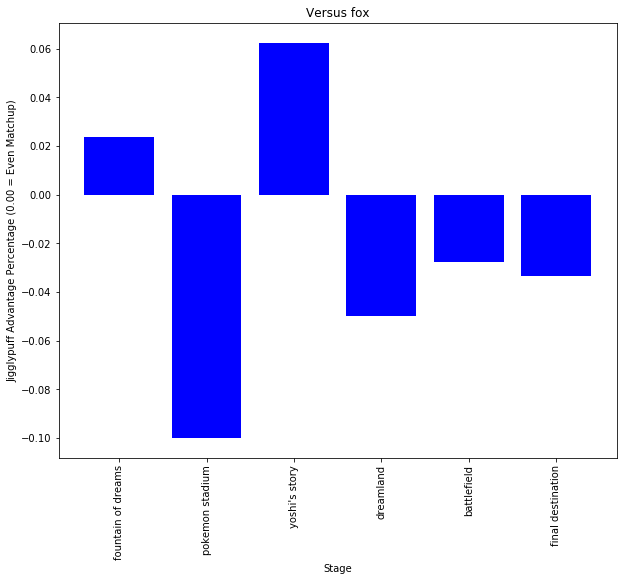

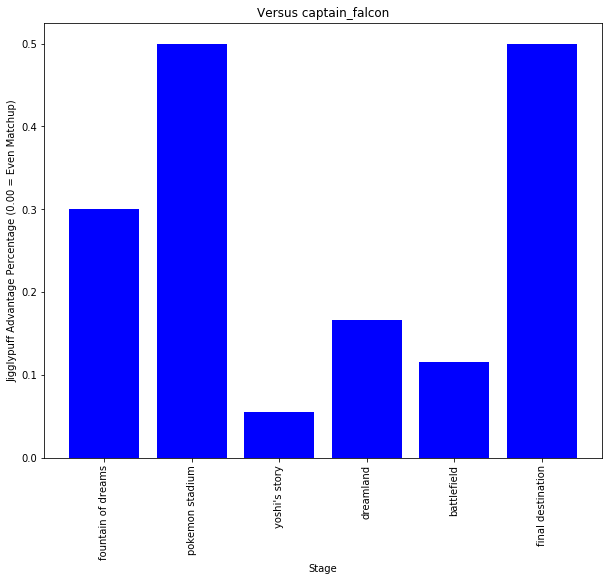

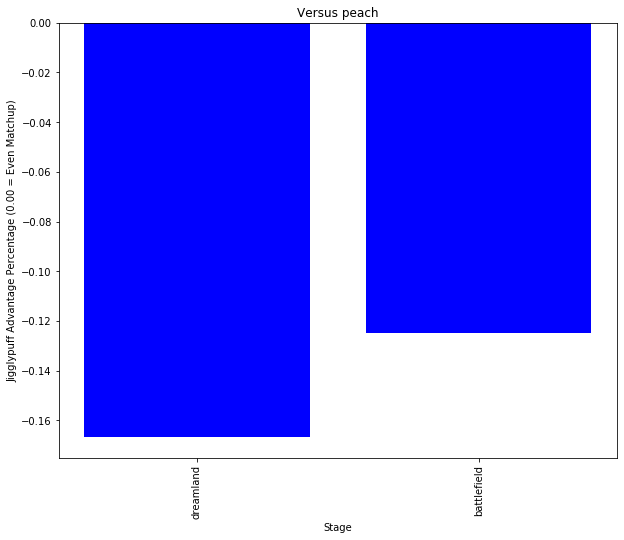

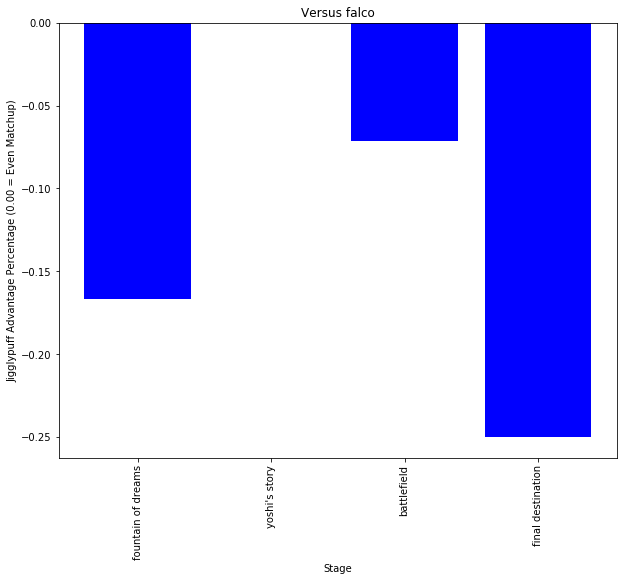

In [8]:
for character in all_characters:
    
    name = character[1]
    x_stages = list()
    y_winrate = list()
    y_winrate_std = list()
    
    for stage in all_stages:
        
        stage_name = stage[1]
        
        matchup_filtered_games = all_games[all_games.matchup == name]
        filtered_games = matchup_filtered_games[matchup_filtered_games.stage == stage_name]
        
        matchup_games = matchup_filtered_games.shape[0]
        matchup_wins = matchup_filtered_games[matchup_filtered_games.win == True].shape[0]
        total_games = filtered_games.shape[0]
        total_wins = filtered_games[filtered_games.win == True].shape[0]
        
        # Only look at matchups for which we have ten or more games
        if matchup_games >= 10:

            # Only display stages on which 3 or more games have been played
            if total_games >= 3:
                x_stages.append(stage_name)
                y_winrate.append(float(total_wins)/float(total_games))
                
                # Standardize our data
                y_winrate_std = list(map(lambda x: x - .5, y_winrate))

    if y_winrate_std:
        
        fig = plt.figure(1, [10, 8])
        plt.title("Versus " + name)
        plt.xticks(rotation='vertical')
        plt.xlabel("Stage")
        plt.ylabel("Jigglypuff Advantage Percentage (0.00 = Even Matchup)")
        plt.bar(x_stages, y_winrate_std, color = 'blue')
        plt.show()

Many of the results are in line with what *Melee* common sense would imply. Large stages such as final destination tend to benefit Jigglypuff since she can survive longer with her excellent recovery (her ability to return to the stage after being knocked off).
However, there are several interesting results which I would like to highlight.
Some of these odd results:

- Having a positive winrate vs Fox on Yoshi's Story. Yoshi's Story is considered to be among the best stages for fox and the worst for Jigglypuff due to its very small size. It is surprising to see Jigglypuff outperforming Fox on his home turf. A possible explanation is the lethality of Jigglypuff's special move "rest" which inflicts tremendous damage and knockback but has the downside of extremely short range and putting Jigglypuff helplessly to sleep for several seconds after its use (a death sentence). The tiny size of the stage means that a successful rest will have a near-100% kill rate.


- The opposite of the above when fighting Marth - a notable disadvantage when fighting on Yoshi's Story. Although rest retains its deadliness, this silver bullet is outweighed by the range provided by Marth's falchion (sword). It appears that Marth's superior range allows him to play "keep-away" well enough that Jigglypuff has trouble getting an opportunity to rest, outweighing the strength of the move on Yoshi's Story. It comes as no surprise that the community has dubbed the stage "Marth's Story".


- Jigglypuff has a very severe disadvantage against Falco on Final Destination. Falco possesses the strongest projectile in the game: a laser that flies far and straight, deals non-negligible damage, and briefly stuns whoever it hits. Final Destination is a large, flat stage that complements Falco's lasers perfectly. Falco can patiently sit on one side of the stage and repeatedly fire lasers at Jigglypuff, forcing her to approach and thereby surrendering her advantage of having a strong defensive game. This clearly outweighs the benefit a large stage provides to Jigglypuff's recovery.

## Finding a Relationiship Between Game Length and Winrate

Another natural question to ask is whether there exists a relationship between how long a game lasts and Jigglypuff's chances of winning.
Here, we divide all the games into ten equal intervals. For all these intervals, we find the average winrate and plot the results.

*Note we only look at intervals which contain five or more games*

In [9]:
duration_ranges = pd.cut(all_games.duration, bins = 10)
groups = all_games.groupby(duration_ranges)

x_intervals = list()
y_winrate = list()

for name, group in groups:
        
    # Only care if there are five or more games in this duration
    if group.shape[0] >= 5:
        
        duration_seconds = str(int(name.left / 60)) + "-" + str(int(name.right / 60))
        
        x_intervals.append(duration_seconds)
        y_winrate.append(group[group.win == True].shape[0] / group.shape[0])
        
plt.rcParams["figure.figsize"] = [16,9]
plt.axhline(y = .5, color = "Black") 
plt.title("Jigglypuff Winrate vs Match Duration")
plt.xlabel("Match Duration (Seconds)")
plt.ylabel("Jigglypuff Winrate Percentage")
plt.scatter(x_intervals, y_winrate)
plt.show()

# Free memory
x_intervals = None
y_winrate = None
gc.collect()

17665

These results are unsurprising. Jigglypuff is a strong defensive character and thrives when her opponent carelessly attacks her. To succeed, you have to "play her game": patiently waiting for an opening and judiciously disengaging when you are not guaranteed a winning engagement. Additionally, Jigglypuff can very quickly end games with skillful use of rest; something that's far more likely against an opponent unfamiliar fighting her. The dataset features many such opponents.

With this in mind, it makes sense that Jigglypuff tends to win when the games end quickly.

## Mapping Jigglypuff's Positioning

*Melee* is all about movement and positioning. Strong gameplay is characterized by deft, smooth movement and positioning your character to be in the right place at the right time. You win a game by hitting your opponent and not getting hit yourself. As such, it's very worthwhile to look at a character's positioning to see where the character "wants to go".

Stage control is also very important in *Melee*. Being more centralized on the stage means being able to maneuver more effectively than your opponent, which again comes back to the above point of positioning in such a way that you are able to land attacks. In general, the more often you have stage control, the more likely you are to win.

Jigglypuff is a bit of an oddity when it comes to stage control. Due to her properties, she is very comfortable playing on the outskirts of a stage and even offstage, meaning stage control is not *quite* as important to her as it is to the rest of the cast (at least in theory). Here, we'll take a look at where Jigglypuff tends to position herself on each stage and compare the result to conventional wisdom.

In [10]:
stage_to_positions = {
    fod[1]: list(),
    stadium[1]: list(),
    yoshis[1]: list(),
    dreamland[1]: list(),
    bf[1]: list(),
    fd[1]: list()
}

for stage, stage_name, fname in all_stages:

    stage_games = all_games[all_games.stage == stage_name]

    for index, row in stage_games.iterrows():

        game = Game('games/' + str(row.filename))
        
        # Every two seconds, record jiggs' position
        for frame in game.frames[0::120]:
            stage_to_positions[stage_name].append(frame.ports[row.jiggs_port].leader.post.position)

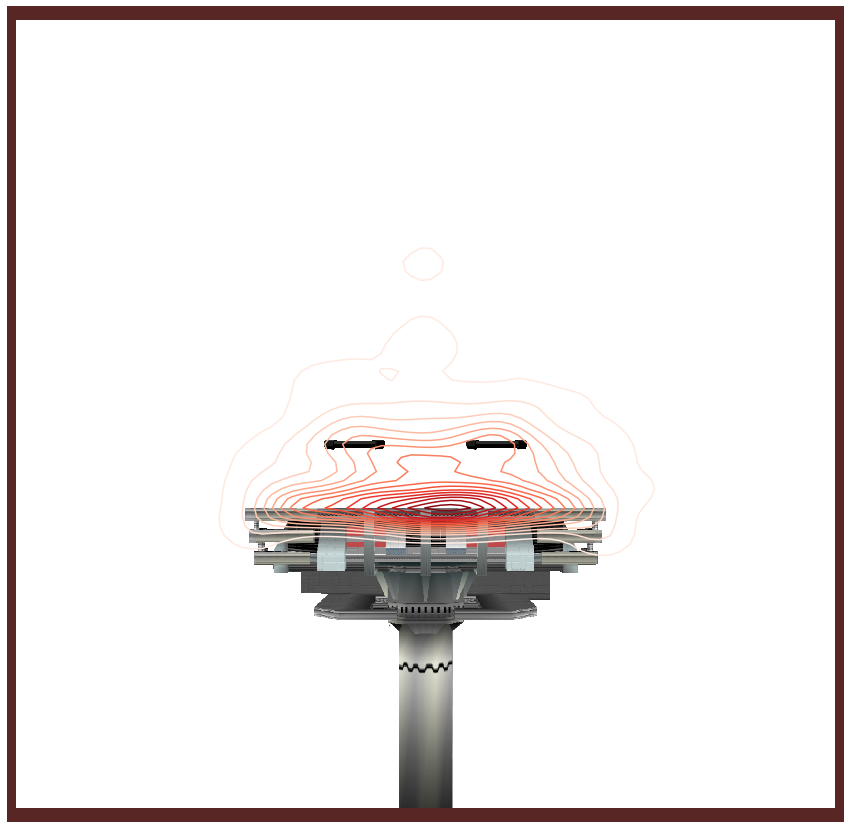

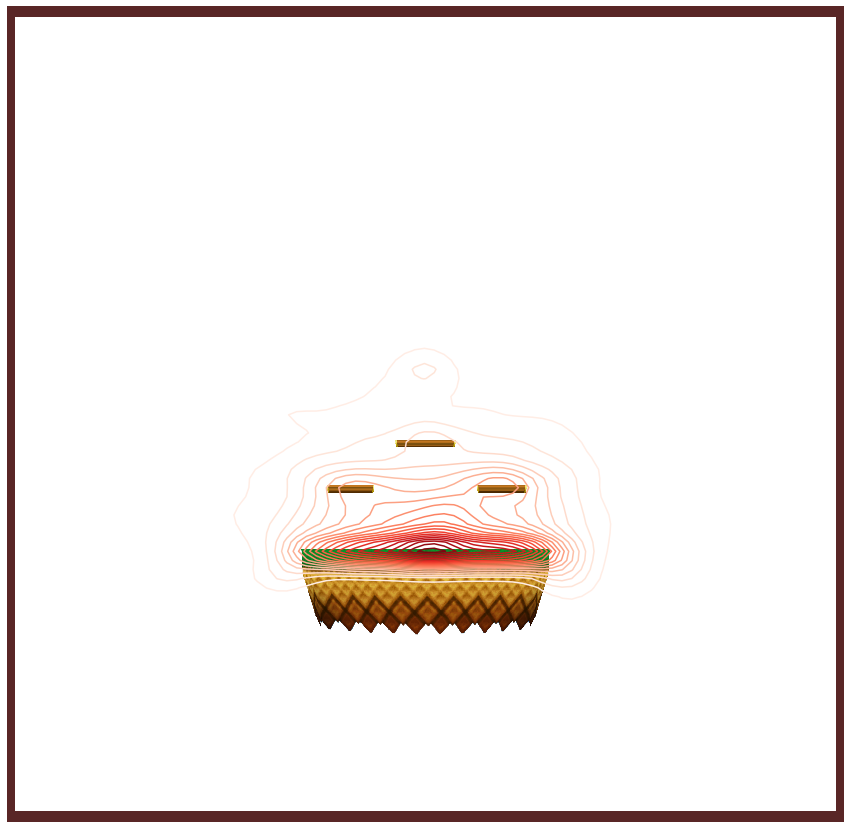

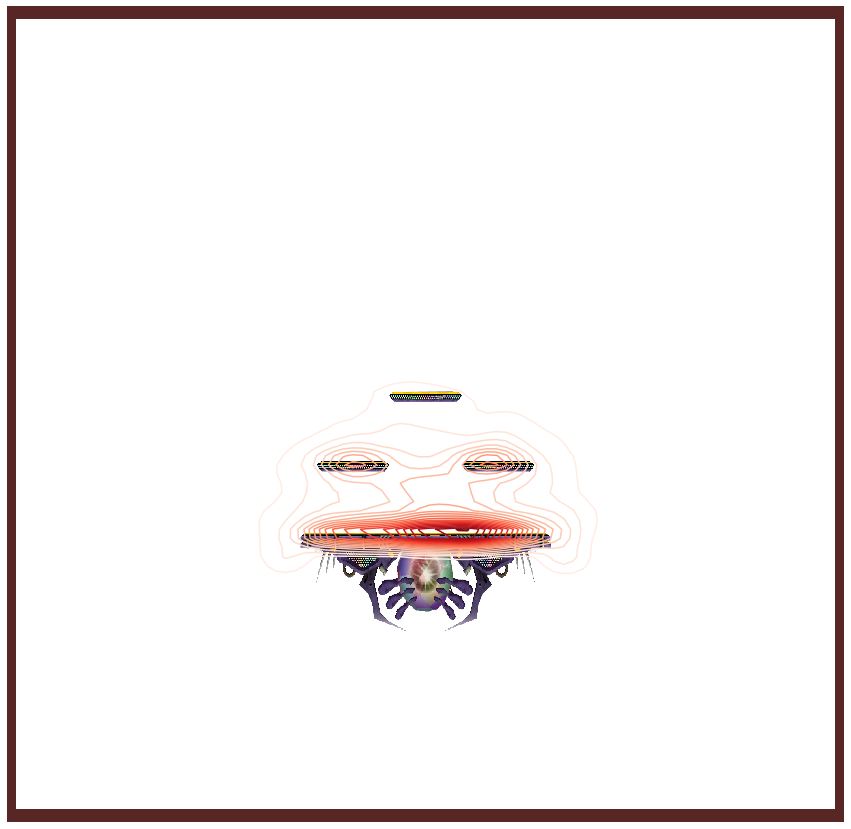

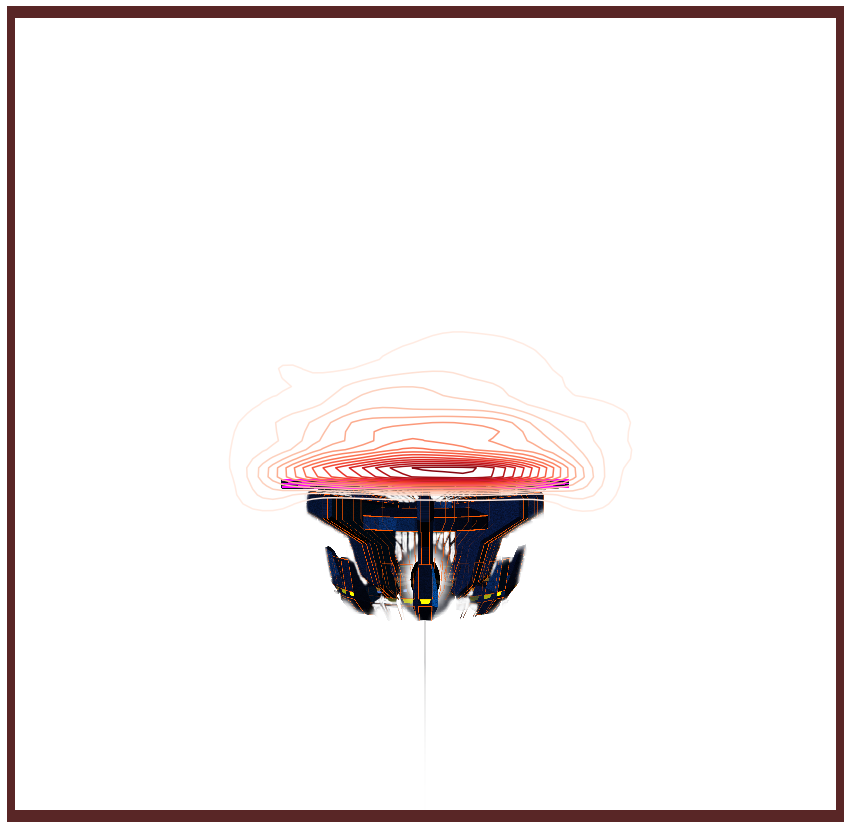

19288

In [11]:
for stage, stage_name, fname in all_stages:
    
    x_pos = [p.x for p in stage_to_positions[stage_name]]
    y_pos = [p.y for p in stage_to_positions[stage_name]]
    
    # call the kernel density estimator function
    ax = sns.kdeplot(x_pos, y_pos, cmap="Reds", shade=False, shade_lowest=False, n_levels = 20)

    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    
    x_left, x_right = stage_boundaries[stage_name][0]
    y_bottom, y_top = stage_boundaries[stage_name][1]
    
    plt.xlim(x_left, x_right)
    plt.ylim(y_bottom, y_top)
    plt.axis('off')

    map_img = mpimg.imread('stages/' + fname)

    #put the map under the heatmap
    im = ax.imshow(map_img, aspect = ax.get_aspect(), extent = ax.get_xlim() + ax.get_ylim(), zorder = 0)

    ax.collections[0].set_alpha(0)
    plt.show()

# Free up some memory
stage_to_positions = None
gc.collect()

The resultant heatmaps are reasonable and are not offensive to *Melee* sensibilities. We see that Jigglypuff spends much of her time on the ground center stage, indicating that players prioritize stage control despite Jigglypuff not living or dying by whether she has control.

One thing that is somewhat surprising is how often Jigglypuff is on the ground. Jigglypuff has among the strongest air games of the cast, meaning that she is very dangerous in the air. Much of her strategy revolves around remaining airborn and throwing out her powerful aerial attacks to either keep opponents offstage or put up a "wall of pain": a barrier of repeated attacks which opponents have significant trouble penetrating. As such, it's strange to see that she spends so much of her time grounded. This can potentially be explained by her propensity for grabs, which frequently lead into combos that end in kills, but is curious regardless.

## Finding Neutral Wins and Killing Blows

A game of *Melee* is divided into two phases: neutral and punish.

Neutral is the game state in which neither player is at a significant positional advantage and both are looking for an opening in order to land the first hit to start a combo, thereby beginning the punish phase.

Punish begins when a player lands a hit and ends neutral. Punish is characterized by the punishing player trying to land as many hits as possible to rack up damage and ideally kill the opponent. The punish phase can be thought of as the combo phase.

We will start by finding the locations in which Jigglypuff tends to be when she wins neutral and lands an attack which kills the opponent.

#### Defining a Neutral Win and Killing Blow

Slippi makes it rather difficult to determine when the "first" hit has been landed and a character wins neutral. Slippi doesn't provide this information; only data on the state of each character and their positions. Thus, we must pin this down ourselves. I took inspiration from the [Slippi JavaScript library](https://github.com/project-slippi/slp-parser-js/blob/16aa92429281c49d4b7c3901f0a2ed989927137c/src/) which defines exactly this, but in a more complex (and admittedly robust) way. 

Our definition is as follows: if an opponent's state changes to "grabbed" or "damaged" and actually took damage in the current frame, then Jigglypuff landed an attack. We start a new combo and append this attack and Jigglypuff's position to it. The combo continues until the opponent does not get hit with an attack for 90 frames (1.5 seconds) or dies. If the 90 frames elapse, we return to neutral and append the combo to a list of conversions. Whenever the opponent dies, we credit the kill to Jigglypuff's last attack of her latest combo.

Once we've parsed the whole game, we are left with a list of "conversions", each a combo, and some number of "kill markers" dispersed between the combos, indicating that the opponent died.

In [12]:
def get_conversions(game, j_port, opp_port):
    
    # The time a character must be in control for neutral to be re-established
    # Currently set to one-and-a-half seconds
    DISENGAGE = 90
    
    # Time since the opponent was last hit with an attack
    opp_time_since_hit = 9999
    
    conversions = list()
    current_combo = list()
    
    # Whether we can count a kill as 'new'
    kill_registerable = True
    
    prev_frame = game.frames[0]
    prev_j_state = prev_frame.ports[j_port].leader.post.state
    prev_opp_state = prev_frame.ports[opp_port].leader.post.state
    
    # Whether the game is in neutral (as oppposed to punish)
    neutral = True
    
    for frame in game.frames[1:]:
        
        f_index = str(frame.index)
        
        j_data = frame.ports[j_port].leader.post
        opp_data = frame.ports[opp_port].leader.post
        
        j_state = j_data.state
        opp_state = opp_data.state
        
        j_damaged = is_damaged(j_state)
        j_grabbed = is_grabbed(j_state)
        j_damage_taken = damage_taken(prev_frame.ports[j_port].leader.post, j_data)
        j_dead = is_dead(j_state)
        j_attacking = is_attacking(j_state)
        j_grabbing = is_grabbing(j_state)
        j_holding = is_holding(j_state)
        j_in_control = is_in_control(j_state)
        j_respawn = is_respawn(j_state)
        j_state_changed = j_state != prev_j_state
        
        opp_damaged = is_damaged(opp_state)
        opp_grabbed = is_grabbed(opp_state)
        opp_damage_taken = damage_taken(prev_frame.ports[opp_port].leader.post, opp_data)
        opp_dead = is_dead(opp_state)
        opp_attacking = is_attacking(opp_state)
        opp_grabbing = is_grabbing(opp_state)
        opp_holding = is_holding(opp_state)
        opp_in_control = is_in_control(opp_state)
        opp_respawn = is_respawn(opp_state)
        opp_state_changed = opp_state != prev_opp_state
        
        if opp_respawn:
            kill_registerable = True
        
        # Opponent got hit or grabbed
        if opp_damaged or opp_grabbed:
            
            opp_time_since_hit = 0
            j_pos = j_data.position
            j_attack = j_data.last_attack_landed
            
            # If we're in neutral, jiggs landed the first hit
            if neutral:
                neutral = False
        
            # Add the attack to the current combo if it's fresh
            if opp_damage_taken:
                current_combo.append((j_attack, j_pos))
        
        # If opponent didn't get hit, increment time since the last hit landed
        else:
            opp_time_since_hit = opp_time_since_hit + 1
        
        # If it's been long enough without a hit, return to neutral
        if opp_time_since_hit > DISENGAGE:
            
            neutral = True
            
            # Reset the combo
            if current_combo:
                conversions.append(current_combo)
                current_combo = list()
        
        # If the opponent died, credit the death to jiggs' last combo
        if opp_dead and kill_registerable:
            
            # Reset the combo
            if current_combo:
                conversions.append(current_combo)
                current_combo = list()
            
            conversions.append("KILL")
            kill_registerable = False
            
        
        prev_frame = frame
        prev_j_state = j_state
        prev_opp_state = opp_state
    
    return conversions


In [13]:
# Now plot heatmaps of neutral wins and kills across all stages

neutral_wins = {
    fod[1]: list(),
    stadium[1]: list(),
    yoshis[1]: list(),
    dreamland[1]: list(),
    bf[1]: list(),
    fd[1]: list()
}

kills = {
    fod[1]: list(),
    stadium[1]: list(),
    yoshis[1]: list(),
    dreamland[1]: list(),
    bf[1]: list(),
    fd[1]: list()
}

for index, row in all_games.iterrows():
    
    game = Game('games/' + row.filename)
    conversions = get_conversions(game, row.jiggs_port, row.opp_port)
    
    # If the game is corrupt and doesn't have the stage, do nothing
    if not row.stage:
        continue
    
    for i in range(len(conversions)):
        
        combo = conversions[i]
 
        # If this is a kill marker
        if isinstance(combo, str):
            
            # If the very first opponent death was a self-destruct without taking any hits, do nothing
            if i == 0:
                continue
                
            # Otherwise, credit the last move hit with the kill
            kills[row.stage].append(conversions[i - 1][-1])
        
        # Append the neutral winner: the move and the position
        else:
            neutral_wins[row.stage].append(combo[0])

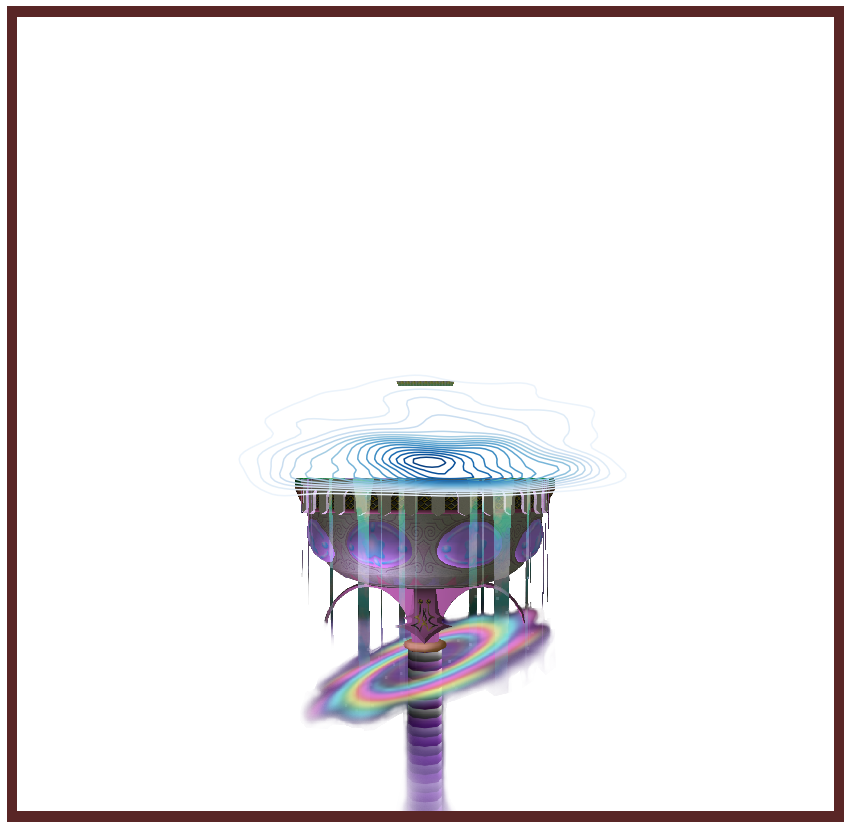

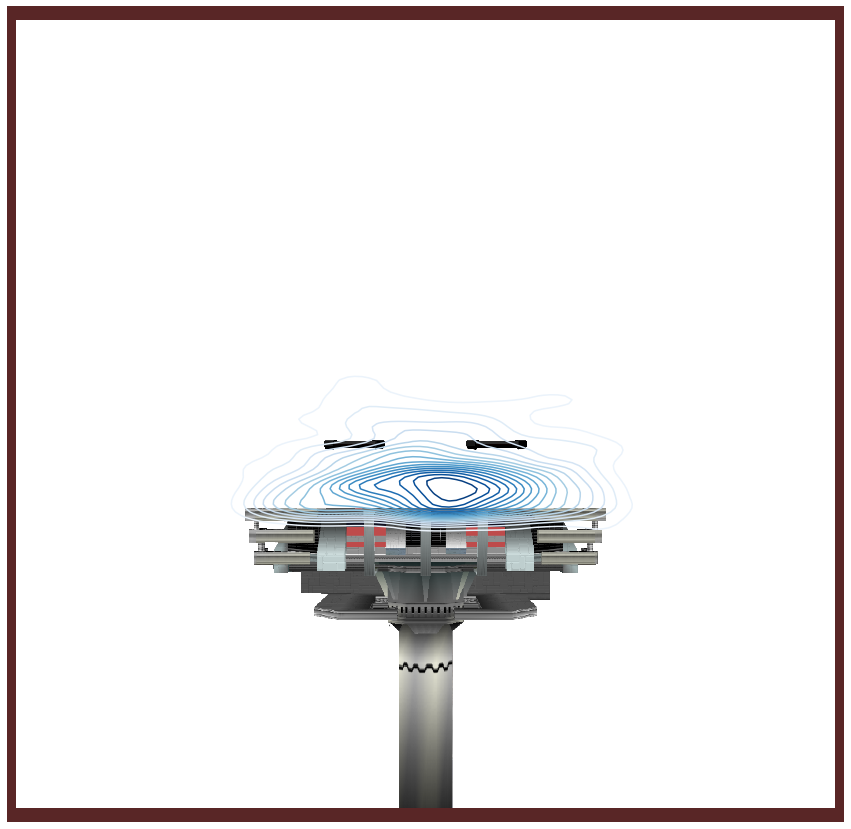

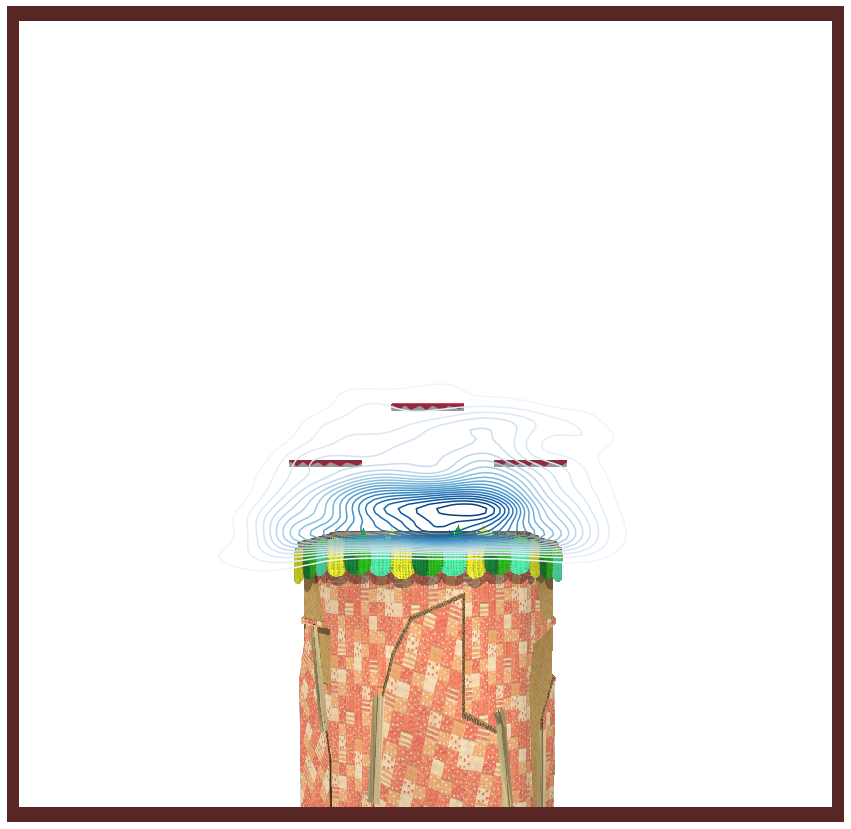

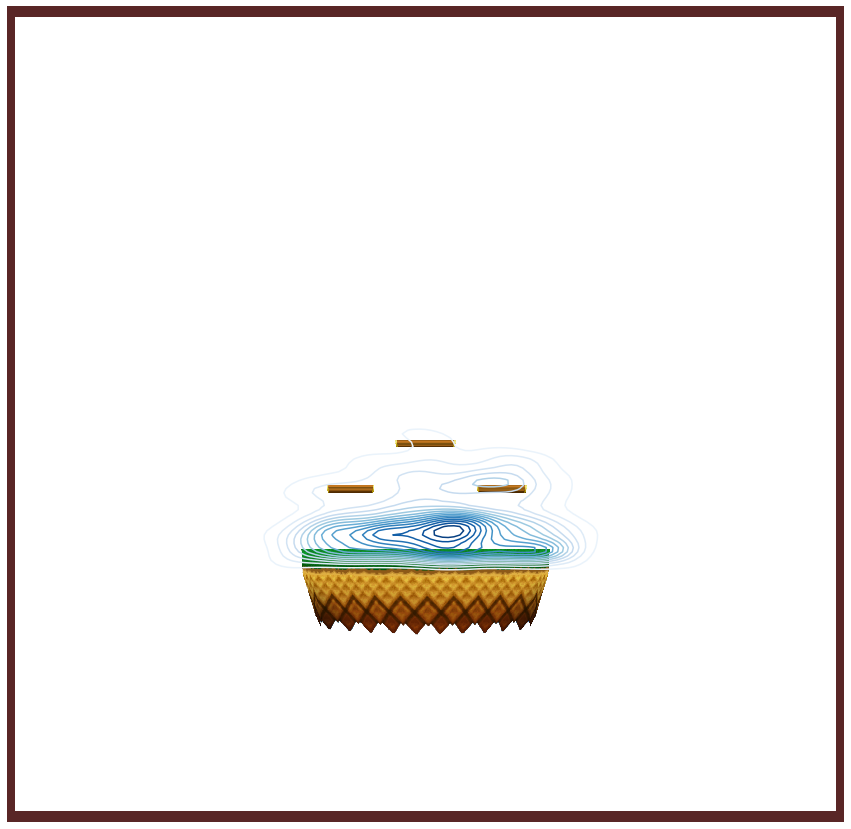

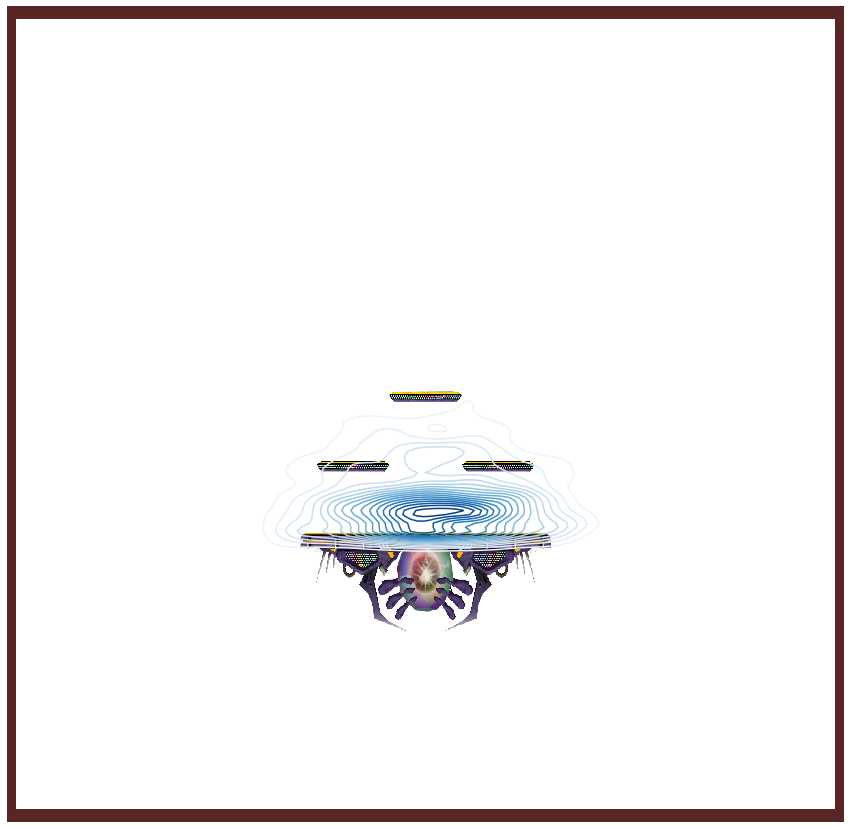

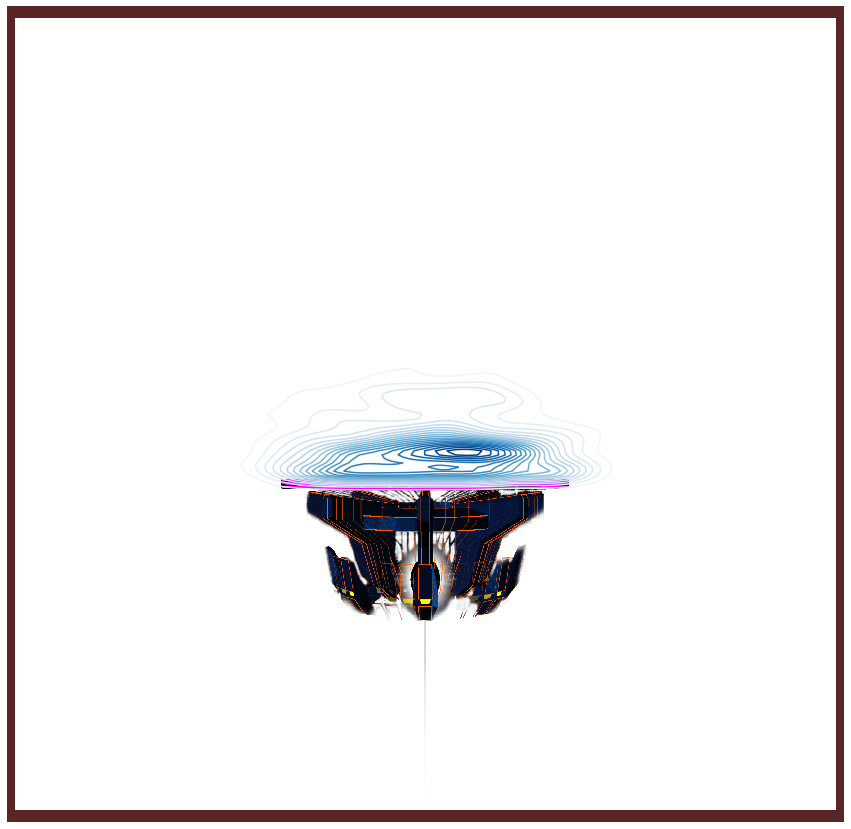

16656

In [14]:
# Map where neutral wins happen

for stage, stage_name, fname in all_stages:
    
    neutral_x_pos = [w[1].x for w in neutral_wins[stage_name]]
    neutral_y_pos = [w[1].y for w in neutral_wins[stage_name]]

    # Plot neutral wins in blue
    ax = sns.kdeplot(neutral_x_pos, neutral_y_pos, cmap="Blues", shade=False, shade_lowest=False, n_levels = 20)

    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    
    x_left, x_right = stage_boundaries[stage_name][0]
    y_bottom, y_top = stage_boundaries[stage_name][1]
    
    plt.xlim(x_left, x_right)
    plt.ylim(y_bottom, y_top)
    plt.axis('off')

    map_img = mpimg.imread('stages/' + fname)

    #put the map under the heatmap
    im = ax.imshow(map_img, aspect = ax.get_aspect(), extent = ax.get_xlim() + ax.get_ylim(), zorder = 0)

    ax.collections[0].set_alpha(0)
    plt.show()
    
# Free memory
neutral_wins = None
gc.collect()

## Neutral Win Results

These results are in line with what we expect of Jigglypuff. She tends to win neutral most often toward the center of the stage, which is where she tends to be positioned most of the time. Additionally, we see that she tends to be airborne when she wins neutral, indicating that she tends to hit with aerial attacks. This finding underlines the obvious strength of her air game and her comparatively weak ground game.

Another important thing to note is that she typically is not on or around a platform when she wins neutral. This is explainable by Jigglypuff having trouble reaching platforms. Although she has extremely good horizontal mobility in the air largely due to her excellent aerial drift (her horizontal speed in the air), her vertical mobility is very poor. She has six jumps, but each one only grants about half the vertical gain that a typical jump would. This is to say, she must use twice as many jumps to reach a platform as most other members of the cast, which is very slow and thus exploitable. 

Overall, Jigglypuff performs best in neutral when she stays airborne close to the ground and is able to use her powerful aerial attacks while remaining mobile.

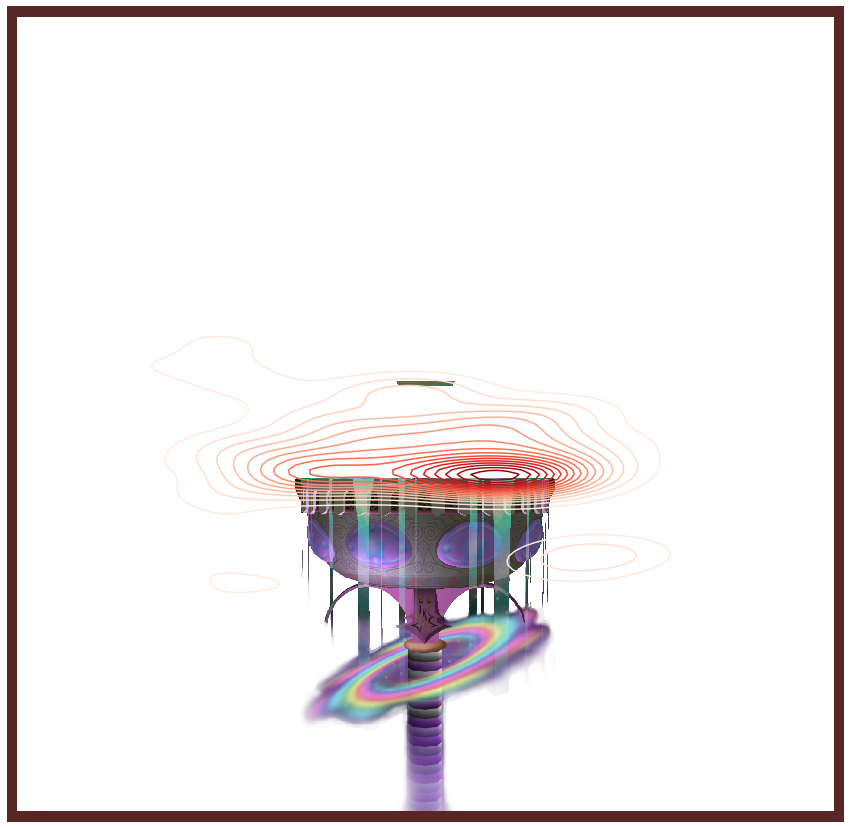

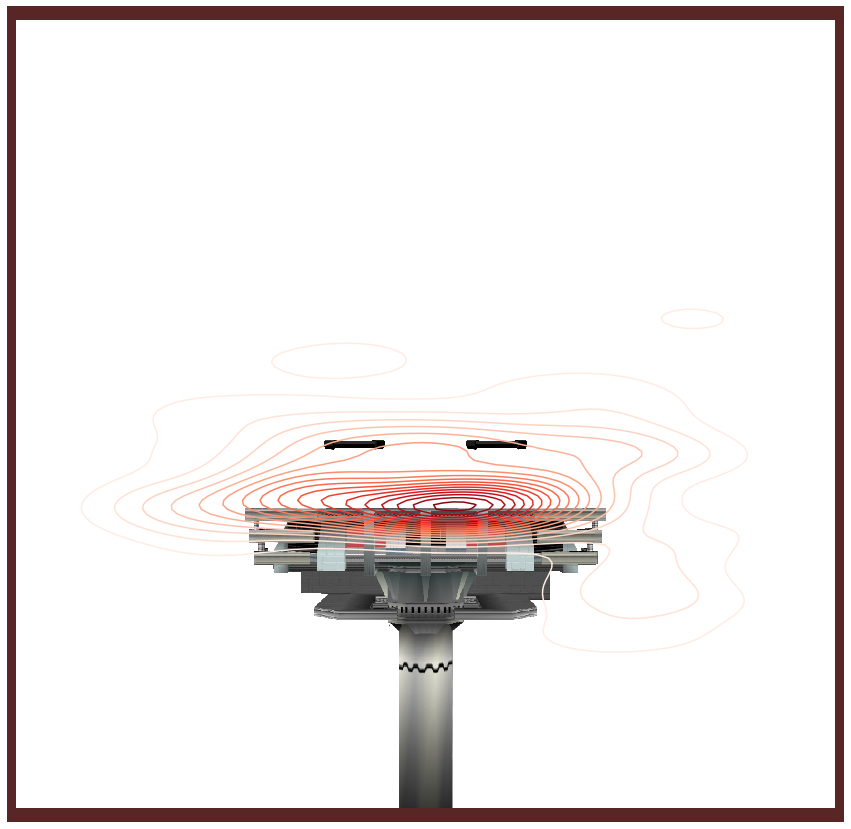

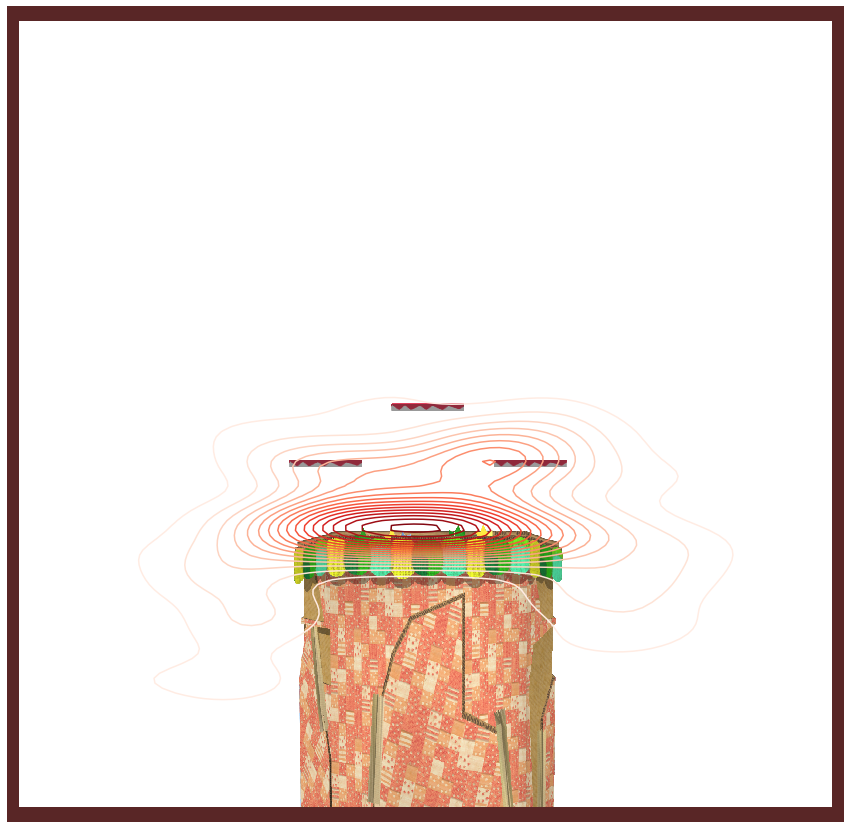

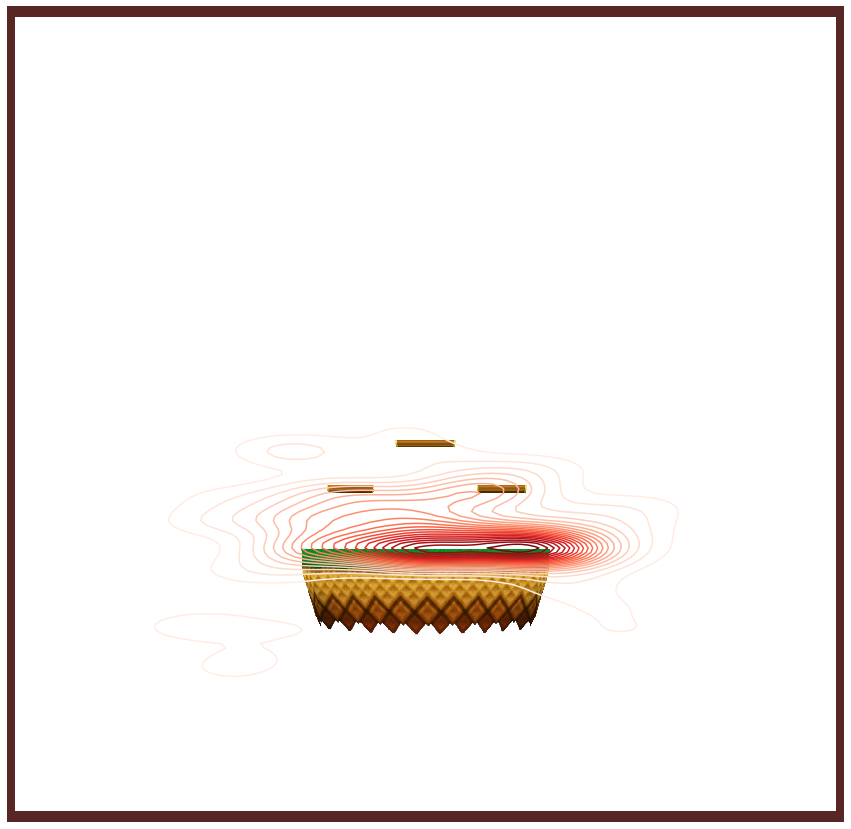

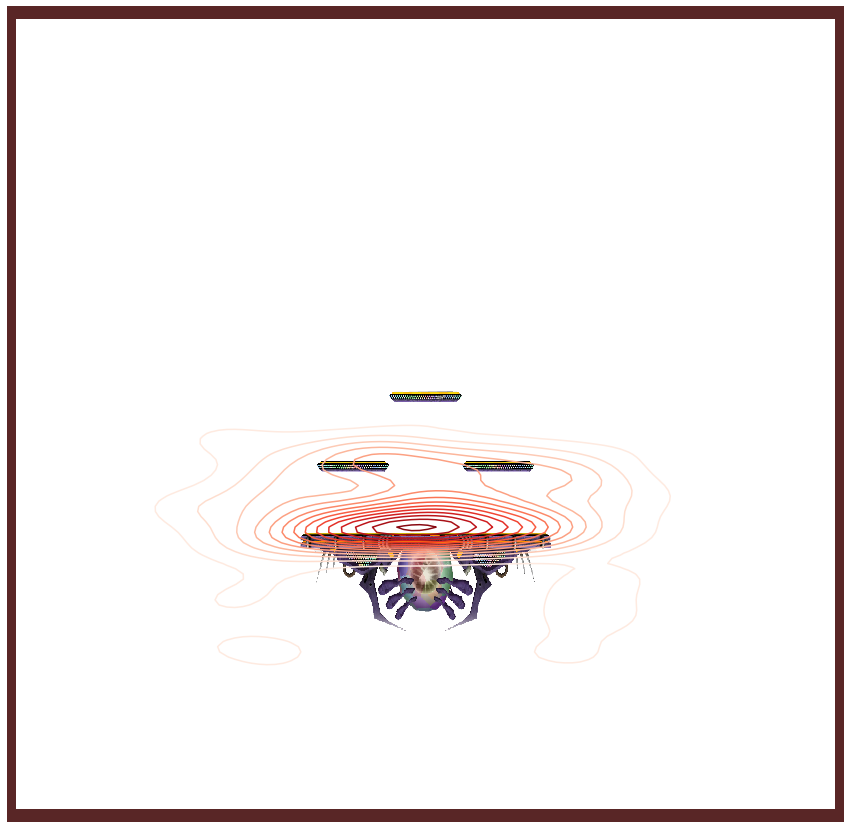

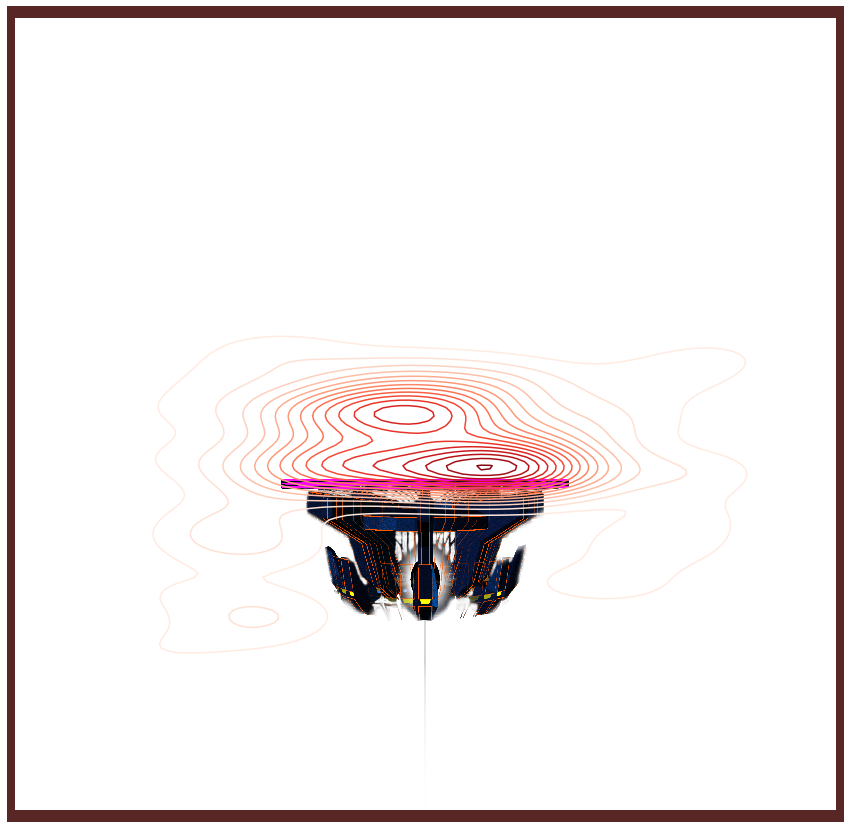

In [15]:
for stage, stage_name, fname in all_stages:
    
    kill_x_pos = list()
    kill_y_pos = list()
    
    for w in kills[stage_name]:
        
        if not isinstance(w, str):
            kill_x_pos.append(w[1].x)
            kill_y_pos.append(w[1].y)
    
    # Plot kills in red
    ax = sns.kdeplot(kill_x_pos, kill_y_pos, cmap="Reds", shade=False, shade_lowest=False, n_levels = 20)

    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    
    x_left, x_right = stage_boundaries[stage_name][0]
    y_bottom, y_top = stage_boundaries[stage_name][1]
    
    plt.xlim(x_left, x_right)
    plt.ylim(y_bottom, y_top)
    plt.axis('off')

    map_img = mpimg.imread('stages/' + fname)

    #put the map under the heatmap
    im = ax.imshow(map_img, aspect = ax.get_aspect(), extent = ax.get_xlim() + ax.get_ylim(), zorder = 0)

    ax.collections[0].set_alpha(0)
    plt.show()

## Killing Blows Results

Here is where things start to get very interesting. 

First of all, we note that her killing blows are similar to her neutral wins in that they tend to avoid platforms and are low to the ground. We will perform some rudimentary analysis on her killing moves that will help explain this further. Overall, this is likely due to her overall positioning trends and slow platform movement.

Now, the **weird** part:

If we look at the distributions, we see that on larger stages, the killing blows are **drastically** skewed to the right side of the stage. This is particularly bizarre given that the stages are symmetrical. What could possibly explain this tendency? First, the inspiration for this analysis: [this smashboards thread](https://smashboards.com/threads/hungryboxs-weird-habit.443184/). The poster performs a similar (albeit more crude) analysis on HungryBox's neutral wins and finds a similarly skewed distribution. The conclusion the poster reaches is that performing certain techniques is easier in one direction than the other. For instance, flicking the control stick is easier to the left than to the right simply as a result of the ergonomics of the GameCube controller itself.

I found this explanation to be unsatisfactory, but couldn't provide one of my own so I looked to the *Melee* community for insight. What resulted was [this reddit thread](https://www.reddit.com/r/SSBM/comments/e9cx9c/jigglypuff_killing_blows_heatmap_yields_bizarre/). There wasn't a single consensus but instead a few notable points:

1. The aforementioned controller ergonomics are indeed the culprit. I'm not sure how much validity there is to this explanation seeing as the distribution on the smaller stages (battlefield in particular) are symmetric.

2. Players tending to practice techniques while facing one direction of the stage and not the other. This is supplemented by the tendency of players to plug their controllers into port 1 while practicing solo. Plugging into port 1 will cause the player's character to spawn toward the left side of the stage and the computer-controlled player on the right. The CPU is often set to "passive" in order to practice combos, meaning they won't move while being wailed on. Additionally, players often reset their positioning to where they initially spawned when they want to try practicing a certain technique again. This reset saves time, but means the direction they practice in remains constant.

3. On dreamland, the right platform is actually [slightly bigger than the one on the left](https://www.reddit.com/r/smashbros/comments/3mxojy/huh_left_platform_is_actually_shorter_than_right/).

That said, I remain unconvinced of these explanations. I leave this strange phenomenon for future generations (or even the reader!) to investigate further.

## Jigglypuff's Deadliest Moves

Now, we look at Jigglypuff's moves which are most likely to be the killing blow. This will provide some insight into the above heatmaps and lead into our final topic.

20045

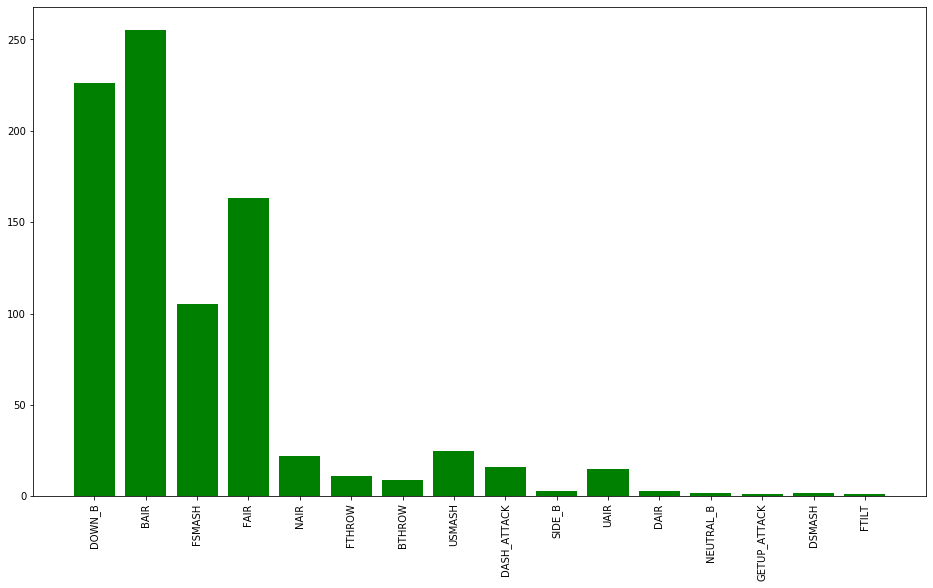

In [16]:
killing_blows = dict()

# Tally up kills for each move
for stage in kills:
    
    for kill_move in kills[stage]:

        move = kill_move[0]
        
        # Ignore kill markers
        if isinstance(move, str):
            continue
        
        if move in killing_blows:
            killing_blows[move] = killing_blows[move] + 1
            
        else:
            killing_blows[move] = 1
            
x_moves = [str(k)[7:] for k in killing_blows.keys()]
y_frequency = [killing_blows[k] for k in killing_blows.keys()]

# Display results
plt.xticks(rotation='vertical')
plt.bar(x_moves, y_frequency, color = "Green")

# Free memory
killing_blows = None
gc.collect()

Again, the results are very much in line with what we expect. We see that Jigglypuff reaps a lot of kills with her aerials; particularly back air and forward air. We also see that she is very reliant on rest to get her kills. Whereas her other moves will almost certainly be distributed evenly since they can reliably hit just by themselves, rest is unique in that it almost necessitates setup. Rest is a high risk, high reward move: if it hits, it has a very high probability of netting a kill. If it misses, Jigglypuff is left totally vulnerable to an optimal punish from the opponent. Given her very low weight, if she has taken even a relatively low amount of damage, she will often suffer a death for her trouble.

There are a few notable rest setups which consistently get kills:

1. Up throw -> rest
2. Up tilt -> rest
3. Up air -> rest
4. Jab reset -> rest (A jab reset is when a character is hit with a weak attack while lying prone on the ground. This causes them to stand up in a predictable manner, granting an easy punish)

Note that many of these setups involve knocking the opponent straight up into the air before hitting them with a rest. Keep this fact in mind while perusing this final section.

## Mapping Rest Kills

Rest is one of Jigglypuff's most powerful tools. It's worthwhile to look where she is most likely to land a lethal rest as it will provide insight into the tool's strengths and weaknesses.

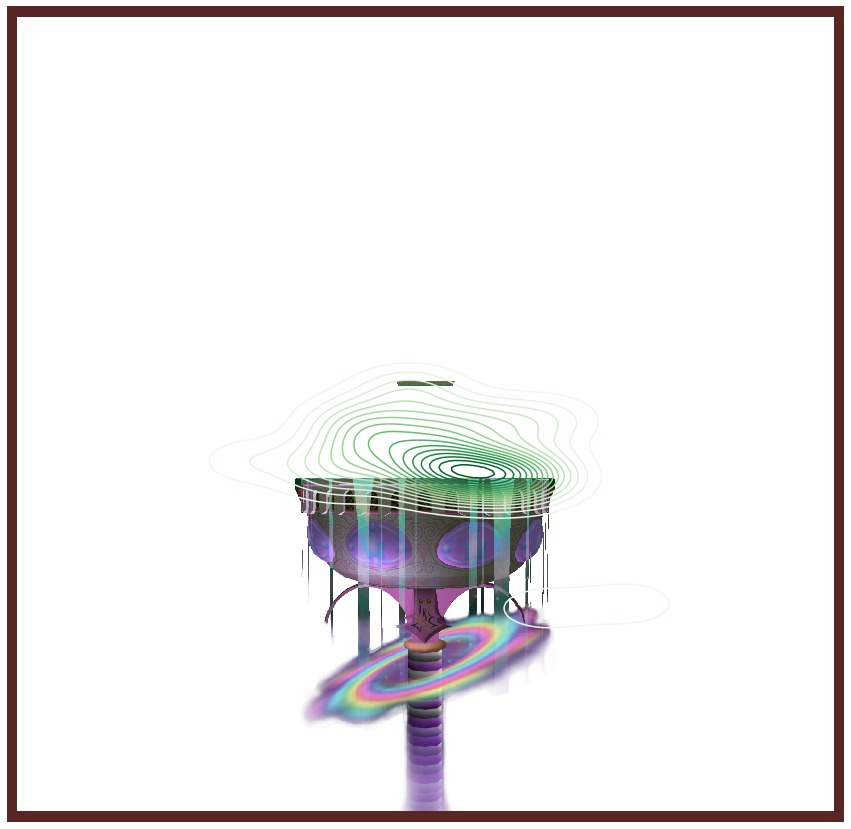

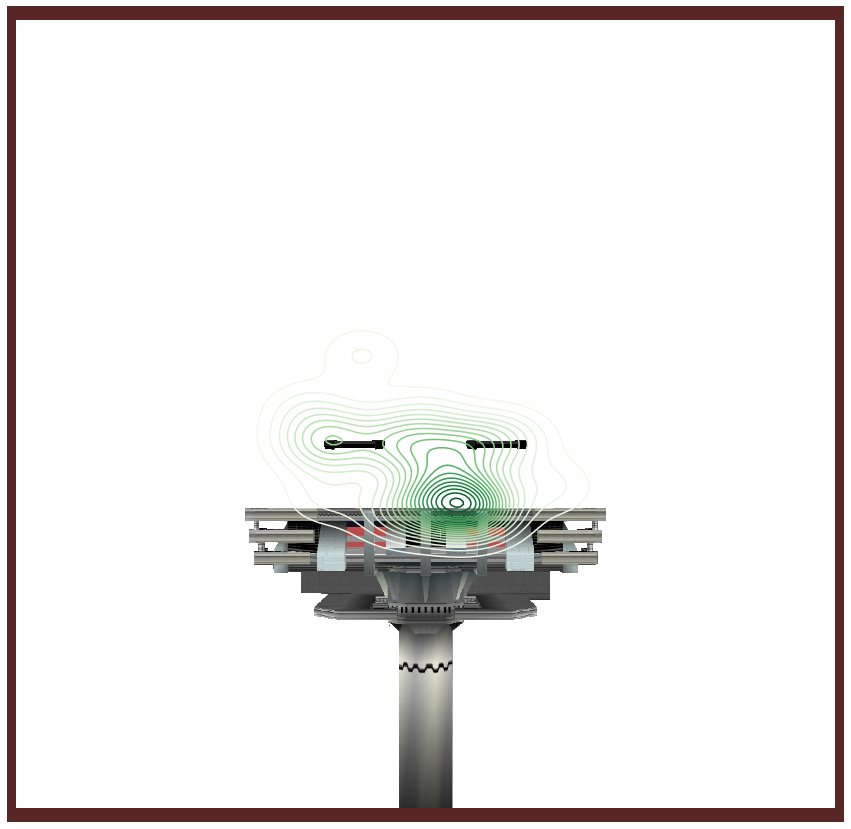

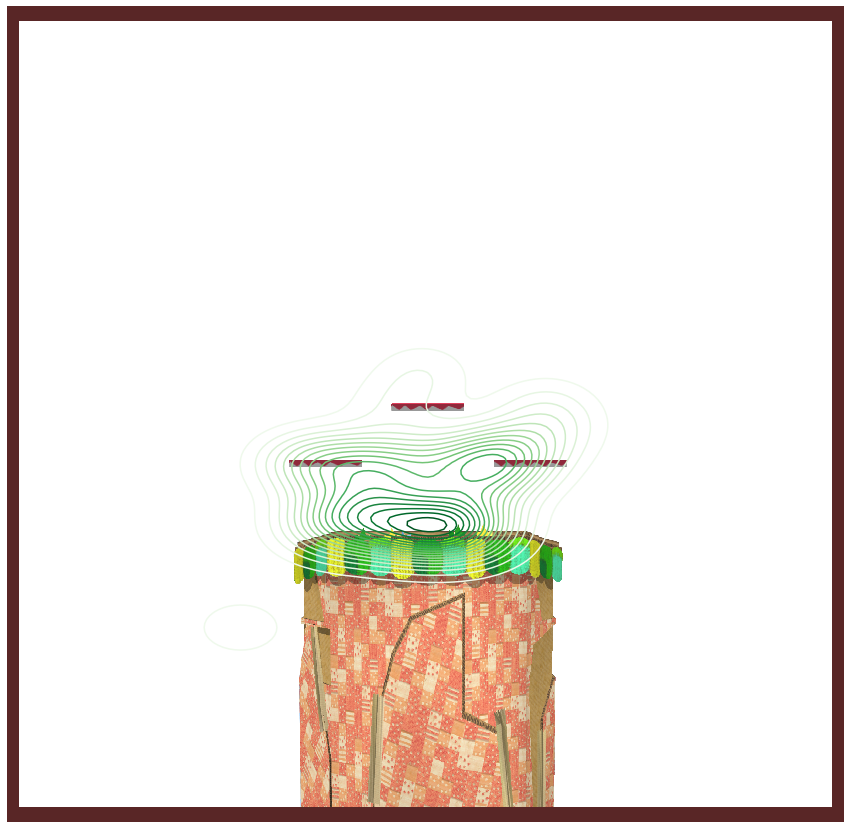

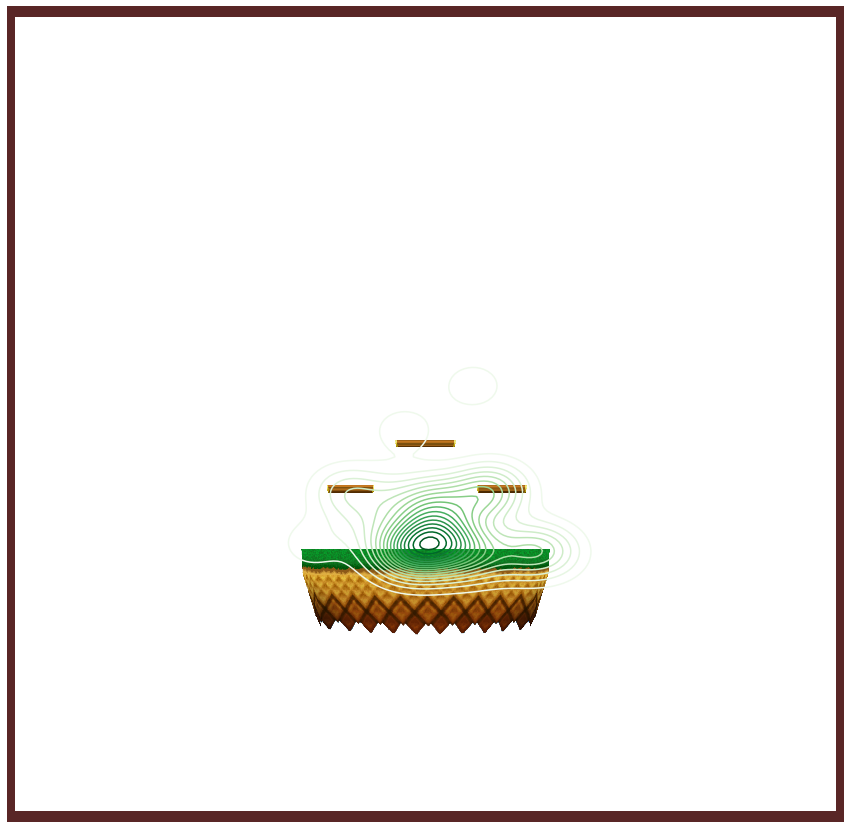

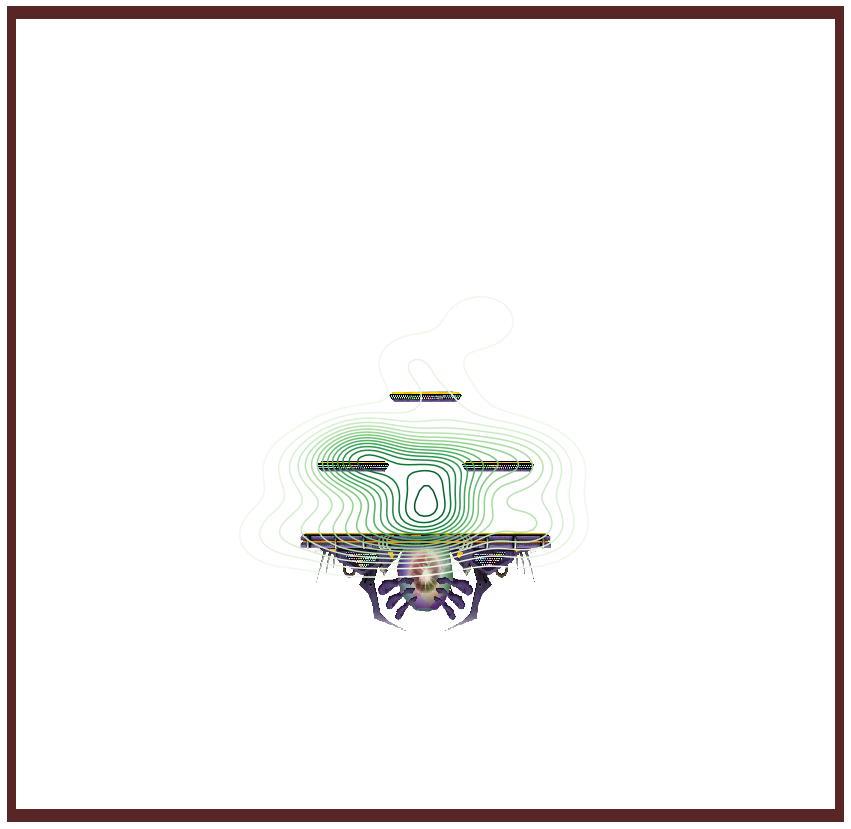

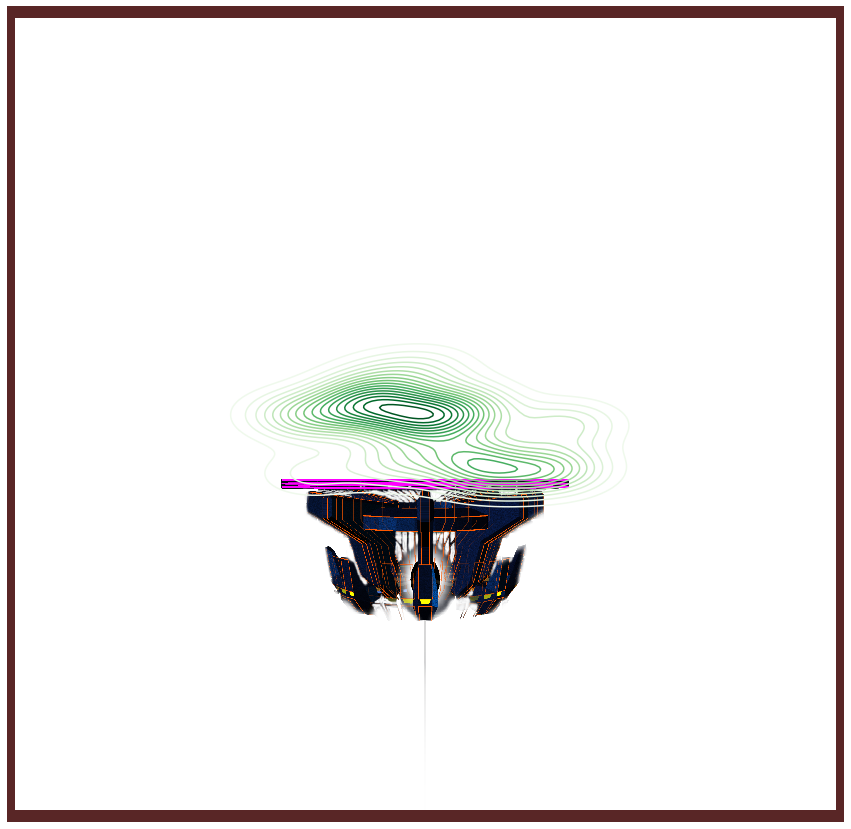

23729

In [17]:
rest_kill_locations = {
    fod[1]: list(),
    stadium[1]: list(),
    yoshis[1]: list(),
    dreamland[1]: list(),
    bf[1]: list(),
    fd[1]: list()
}

for stage in kills:
    
    for kill_move in kills[stage]:
        
        move = kill_move[0]
        
        # Ignore kill markers and attacks other than rest
        if isinstance(move, str) or move != 21:
            continue
        
        location = kill_move[1]
        
        rest_kill_locations[stage].append(location)

for stage, stage_name, fname in all_stages:
    
    kill_x_pos = list()
    kill_y_pos = list()
    
    for w in rest_kill_locations[stage_name]:
        
        kill_x_pos.append(w.x)
        kill_y_pos.append(w.y)
    
    # Plot kills in red
    ax = sns.kdeplot(kill_x_pos, kill_y_pos, cmap="Greens", shade=False, shade_lowest=False, n_levels = 20)

    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    
    x_left, x_right = stage_boundaries[stage_name][0]
    y_bottom, y_top = stage_boundaries[stage_name][1]
    
    plt.xlim(x_left, x_right)
    plt.ylim(y_bottom, y_top)
    plt.axis('off')

    map_img = mpimg.imread('stages/' + fname)

    #put the map under the heatmap
    im = ax.imshow(map_img, aspect = ax.get_aspect(), extent = ax.get_xlim() + ax.get_ylim(), zorder = 0)

    ax.collections[0].set_alpha(0)
    plt.show()
    
# Free memory
rest_kill_locations = None
kills = None
gc.collect()

We find that Jigglypuff tends to land rests while airborne, typically after one of the above setups. The most important point to note is how these kills tend to occur where platforms *are not*. This is likely due to the existance of "techs". When a character is in hitstun and lands on a solid surface, they will land prone and helpless *unless* they pull the left or right trigger on the controller right before they land. When this happens, the character performs a tech, which causes them to stand up (or roll left or right) instantly while invincible. This makes landing a rest much, much harder. In fact, it is advisable that Jigglypuff avoid performing rest setups below platforms for this very reason, and the data makes this all the more clear.

We also see a skewed distribution on Fountain of Dreams and Final Destination, similar to the one we found for killing blows and likely for the same reason (whatever it may be).

Finally, we see an increased number of airborne rests on Final Destination. This is likely due to the stage's lack of platforms, meaning that rest setups are viable everywhere, rather than in certain horizontal intervals.

## Conclusion

This exploratory analysis is only scratching the surface of what is possible with Project Slippi. There is a tremendous amount of insight we can gain into the game using these tools. Even these few basic heatmaps provide a wealth of information which will only be augmented with more data. The methods used in this analysis are very rudimentary and can definitely be improved upon by a more experienced data scientist to eke out more information. *Melee*'s future is bright when we are still learning more nearly 20 years after release.

*Melee* is a beautiful game unlike any other and I hope that this analysis has demonstrated some small degree of the depth that the game possesses. I encourage you to look into the game for yourself and perhaps try it out. It's a rewarding experience unlike any other.